# Topic Model Exploration

BOW, Document-term matrix, TF-IDF. Based on tutorials: https://radimrehurek.com/gensim/tut1.html

In [1]:
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# test corpora based on: http://topicmodels.west.uni-koblenz.de/ckling/tmt/part1.pdf
'''documents = ["probabilistic topic model",
    "probabilistic topic model",
    "probabilistic topic model",
    "probabilistic topic model",
    "probabilistic topic model",
    "probabilistic topic model",
    "probabilistic topic model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model"
]'''
'''documents = ["probabilistic topic model",
    "probabilistic topic model",
    "probabilistic topic model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model",
    "famous fashion model"
]'''
documents = ["modem the steering linux. modem, linux the modem. steering the modem. linux!",
    "linux; the linux. the linux modem linux. the modem, clutch the modem. gear.",
    "gear! clutch the steering, steering, linux. the steering clutch gear. clutch the gear; the clutch.",
    "the the the. clutch clutch clutch! steering gear; steering gear gear; steering gear!!!!"]
len(documents)

4

In [3]:
from nltk.tokenize import word_tokenize
import string

texts = [[word for word in word_tokenize(document) if word not in string.punctuation] for document in documents]
print(texts)

[['modem', 'the', 'steering', 'linux', 'modem', 'linux', 'the', 'modem', 'steering', 'the', 'modem', 'linux'], ['linux', 'the', 'linux', 'the', 'linux', 'modem', 'linux', 'the', 'modem', 'clutch', 'the', 'modem', 'gear'], ['gear', 'clutch', 'the', 'steering', 'steering', 'linux', 'the', 'steering', 'clutch', 'gear', 'clutch', 'the', 'gear', 'the', 'clutch'], ['the', 'the', 'the', 'clutch', 'clutch', 'clutch', 'steering', 'gear', 'steering', 'gear', 'gear', 'steering', 'gear']]


In [4]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
print(dictionary.token2id)

C:\Users\narho_000\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


{'modem': 0, 'the': 1, 'steering': 2, 'linux': 3, 'clutch': 4, 'gear': 5}


In [5]:
bow = [dictionary.doc2bow(text) for text in texts]
bow

[[(0, 4), (1, 3), (2, 2), (3, 3)],
 [(0, 3), (1, 4), (3, 4), (4, 1), (5, 1)],
 [(1, 4), (2, 3), (3, 1), (4, 4), (5, 3)],
 [(1, 3), (2, 3), (4, 3), (5, 4)]]

In [6]:
from gensim.matutils import corpus2dense
bow_dense = corpus2dense(bow, len(dictionary.token2id), len(bow))

In [7]:
import pandas as pd

columns = [f'D{i+1}' for i, doc in enumerate(bow)]
bow_df = pd.DataFrame(bow_dense, columns = columns, index = dictionary.token2id)
print(bow_df)

           D1   D2   D3   D4
modem     4.0  3.0  0.0  0.0
the       3.0  4.0  4.0  3.0
steering  2.0  0.0  3.0  3.0
linux     3.0  4.0  1.0  0.0
clutch    0.0  1.0  4.0  3.0
gear      0.0  1.0  3.0  4.0


In [8]:
from gensim import models

model = models.TfidfModel(bow)
tfidf = [model[doc] for doc in bow]
tfidf

[[(0, 0.936603022962913), (2, 0.19436268823376643), (3, 0.29154403235064963)],
 [(0, 0.8624176140851579),
  (3, 0.47724753317857443),
  (4, 0.11931188329464361),
  (5, 0.11931188329464361)],
 [(2, 0.50709255283711),
  (3, 0.1690308509457033),
  (4, 0.6761234037828132),
  (5, 0.50709255283711)],
 [(2, 0.5144957554275266), (4, 0.5144957554275266), (5, 0.6859943405700354)]]

In [9]:
tfidf_dense = corpus2dense(tfidf, len(dictionary.token2id), len(bow))

In [10]:
tfidf_df = pd.DataFrame(tfidf_dense, columns = columns, index = dictionary.token2id)
print(tfidf_df)

                D1        D2        D3        D4
modem     0.936603  0.862418  0.000000  0.000000
the       0.000000  0.000000  0.000000  0.000000
steering  0.194363  0.000000  0.507093  0.514496
linux     0.291544  0.477248  0.169031  0.000000
clutch    0.000000  0.119312  0.676123  0.514496
gear      0.000000  0.119312  0.507093  0.685994


# SVD, LSA (LSI)

## Plotting helper functions

In [11]:
def autolabel(ax, rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % height,
                ha='center', va='bottom')

In [12]:
def plot_topics(topics):
    import matplotlib.pyplot as plt
    from numpy import arange

    rects = []
    fig, ax = plt.subplots()
    ind = arange(len(topics[0][1]))
    for ttuple in topics:
        sig_words = ttuple[1]
        sig_words.sort(key=lambda x: x[0])

        xlabels = [word[0] for word in sig_words]
        loadings = [word[1] for word in sig_words]
        width = 0.35

        rect = ax.bar(ind, loadings, width)
        rects.append(rect)

        # add some text for labels, title and axes ticks
        ax.set_ylabel('Loadings')
        ax.set_title('Show topics')
        ax.set_xticks(ind + width / 2)
        ax.set_xticklabels(xlabels)

        ind = ind + width

    for rect in rects:
        autolabel(ax, rect)
    ax.legend(rects, [f'Topic{i}' for i in arange(len(rects))])
    plt.show()

## On bow matrix, with gensim

In [13]:
lsi = models.LsiModel(bow, id2word=dictionary, num_topics=2) # initialize an LSI transformation
lsi.print_topics(-1)

[(0,
  '-0.624*"the" + -0.384*"clutch" + -0.376*"gear" + -0.364*"steering" + -0.335*"linux" + -0.277*"modem"'),
 (1,
  '-0.583*"modem" + -0.514*"linux" + 0.412*"gear" + 0.397*"clutch" + 0.242*"steering" + -0.099*"the"')]

In [14]:
topics = lsi.show_topics(-1, formatted=False)
print(topics)

[(0, [('the', -0.62416736840057163), ('clutch', -0.38393822191950017), ('gear', -0.37630578030717216), ('steering', -0.36351351385925984), ('linux', -0.33508594287100646), ('modem', -0.27744519064591872)]), (1, [('modem', -0.58267249739909854), ('linux', -0.51399462987764832), ('gear', 0.41204140464414329), ('clutch', 0.39735844875013471), ('steering', 0.24249521547000216), ('the', -0.0991286828902809)])]


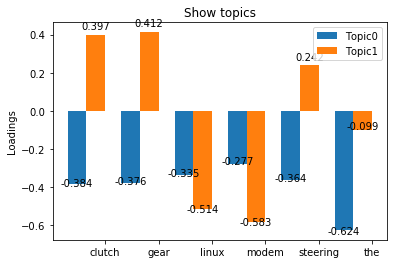

In [15]:
plot_topics(topics)

**Important Note:** Interpretation of the _topic loadings_ (the coefficients associated with each probable word in a topic) is a major difficulty with LSI/LSA - [some](https://www.quora.com/What-is-the-interpretation-of-negative-scores-in-the-basis-vectors-obtained-with-LSI/answer/Luis-Argerich?srid=3A71), like this gensim LSI model, assign words to topics using highest absolute value/magnitude. [Others](https://www.slideshare.net/vitomirkovanovic/topic-modeling-for-learning-analytics-researchers-lak15-tutorial/65) assign with the highest signed value.

**Important Note:** Notice the effect of not cleaning up _stop words_ when running LSA on the term frequency matrix. 'the' has been determined to be the most important word in the most important topic (in both magnitude and signed interpretations of _topic loadings_), which rings false.

**TODO:** Word->Loading bar charts for each topic (like http://topicmodels.west.uni-koblenz.de/ckling/tmt/part1.pdf)

In [16]:
print(lsi.projection.u) # left singular vectors (U)

[[-0.27744519 -0.5826725 ]
 [-0.62416737 -0.09912868]
 [-0.36351351  0.24249522]
 [-0.33508594 -0.51399463]
 [-0.38393822  0.39735845]
 [-0.37630578  0.4120414 ]]


In [17]:
print(lsi.projection.s) # singular values (Ʃ)

[ 11.25526786   6.53892079]


In [18]:
corpus_lsi = lsi[bow] # create a wrapper over the original corpus: bow->fold-in-lsi

# https://github.com/RaRe-Technologies/gensim/wiki/Recipes-&-FAQ#q3-how-do-you-calculate-the-matrix-v-in-lsi-space
print((corpus2dense(corpus_lsi, len(lsi.projection.s)).T / lsi.projection.s).T) # right singular vectors (V^T)

[[-0.41887654 -0.48240457 -0.58523405 -0.4993289 ]
 [-0.56355929 -0.51860406  0.40412391  0.50013462]]


In [19]:
for doc in corpus_lsi: # doc inference: bow->lsi transformation is actually executed here, on the fly
     print(doc)
        
# TODO: why are these numbers so big (and not < 1)?

[(0, -4.7145677241169306), (1, -3.6850694969601783)]
[(0, -5.4295928192507432), (1, -3.3911108898747355)]
[(0, -6.5869661866505931), (1, 2.642534293904204)]
[(0, -5.6200804337666854), (1, 3.2703405625661421)]


## On bow matrix, with scikit-learn

In [20]:
from sklearn.utils.extmath import randomized_svd
from gensim.matutils import corpus2csc

# requires sparse matrix form of bow
bow_sparse = corpus2csc(bow)
U, Sigma, VT = randomized_svd(bow_sparse, n_components=2)

In [21]:
print(U)

[[ 0.27744519  0.5826725 ]
 [ 0.62416737  0.09912868]
 [ 0.36351351 -0.24249522]
 [ 0.33508594  0.51399463]
 [ 0.38393822 -0.39735845]
 [ 0.37630578 -0.4120414 ]]


In [22]:
print(Sigma)

[ 11.25526786   6.53892079]


In [23]:
print(VT)

[[ 0.41887655  0.48240458  0.58523407  0.49932889]
 [ 0.56355928  0.51860406 -0.40412392 -0.5001346 ]]


Using [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) below to 1) perform dimensionality reduction on the doc-term matrix, 2) get extra characteristics like explained variance

In [24]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=1)
svd.fit(bow_sparse)
print(svd.transform(bow_sparse)) # dimensionality reduction on original bow matrix: word inference (TODO: right?)

[[ 3.12271994  3.81004931]
 [ 7.02517092  0.64819461]
 [ 4.09144197 -1.58565701]
 [ 3.77148204  3.36097017]
 [ 4.32132753 -2.59829542]
 [ 4.23542236 -2.69430611]]


In [25]:
'''SVD suffers from a problem called "sign indeterminancy", which means the
sign of the ``components_`` and the output from transform depend on the
algorithm and random state. To work around this, fit instances of this
class to data once, then keep the instance around to do transformations.'''
print(svd.components_) # V^T

[[ 0.41887655  0.48240458  0.58523407  0.49932889]
 [ 0.56355928  0.51860406 -0.40412392 -0.5001346 ]]


**TODO**: write about signification of explained variance

In [26]:
print(svd.singular_values_)

[ 11.25526786   6.53892079]


In [27]:
print(svd.explained_variance_)

[ 1.50696752  7.10165316]


In [28]:
print(svd.explained_variance_ratio_)

[ 0.15816569  0.74536301]


## On tf-idf matrix, with gensim

In [29]:
lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=2) # initialize an LSI transformation
topics = lsi.show_topics(-1, formatted=False)
topics

[(0,
  [('modem', 0.59280867897579537),
   ('clutch', 0.44086098310754523),
   ('gear', 0.43846231302340349),
   ('steering', 0.40457453895574524),
   ('linux', 0.31351189162667215),
   ('the', -2.2589369680319314e-17)]),
 (1,
  [('modem', -0.70667985454335425),
   ('gear', 0.4184650866994219),
   ('clutch', 0.41229356914699122),
   ('steering', 0.31574804740101986),
   ('linux', -0.23623661400957208),
   ('the', -4.6657801499472514e-17)])]

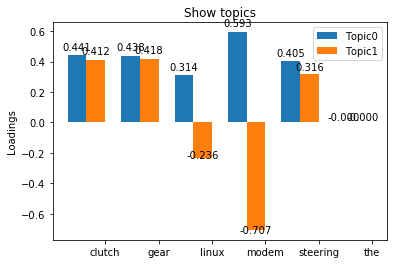

In [30]:
plot_topics(topics)

Interesting results. On the bright side, tf-idf LSA correctly gives the stopword 'the' a loading of ~0, which bow LSA struggled with.

However, the topics are not very interpretable: all words in topic 0 have very similar topic loadings, topic 1 has a clear separation between the word 'modem' and the rest of the field (from the magnitude perspective), and you can really only see the separation between the 'cars' and 'IT' words by using sign in topic 1.

Comparing loadings per word across topics, the higher magnitudes mostly come from the same topic for this example (topic 0 - the only max that comes from topic 1 is for _modem_). **TODO:** is this cross-topic comparison valid, or should I stick with the separate word->loading bar charts per topic?

In [31]:
print(lsi.projection.u) # left singular vectors (U)

[[  5.92808679e-01  -7.06679855e-01]
 [ -2.25893697e-17  -4.66578015e-17]
 [  4.04574539e-01   3.15748047e-01]
 [  3.13511892e-01  -2.36236614e-01]
 [  4.40860983e-01   4.12293569e-01]
 [  4.38462313e-01   4.18465087e-01]]


In [32]:
print(lsi.projection.s) # singular values (Ʃ)

[ 1.50330866  1.28357349]


In [33]:
corpus_lsi = lsi[tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

# https://github.com/RaRe-Technologies/gensim/wiki/Recipes-&-FAQ#q3-how-do-you-calculate-the-matrix-v-in-lsi-space
print((corpus2dense(corpus_lsi, len(lsi.projection.s)).T / lsi.projection.s).T) # right singular vectors (V^T)

[[ 0.48244458  0.50939982  0.5179025   0.48942423]
 [-0.52149894 -0.48542378  0.47612706  0.51546638]]


In [34]:
for doc in corpus_lsi: # doc inference: both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
     print(doc)

[(0, 0.72526311682447597), (1, -0.66938222377208656)]
[(0, 0.76578514191849456), (1, -0.62307711556749079)]
[(0, 0.77856731972283155), (1, 0.61114406793638687)]
[(0, 0.73575565287651989), (1, 0.66163900269049891)]


## On tf-idf matrix, with scikit-learn

In [35]:
from sklearn.utils.extmath import randomized_svd

# randomized_svd requires sparse matrix form of tfidf
tfidf_sparse = corpus2csc(tfidf)
U, Sigma, VT = randomized_svd(tfidf_sparse, n_components=2)

In [36]:
print(U)

[[  5.92808679e-01   7.06679855e-01]
 [ -7.74993893e-24  -2.38175662e-22]
 [  4.04574539e-01  -3.15748047e-01]
 [  3.13511892e-01   2.36236614e-01]
 [  4.40860983e-01  -4.12293569e-01]
 [  4.38462313e-01  -4.18465087e-01]]


In [37]:
print(Sigma)

[ 1.50330866  1.28357349]


In [38]:
print(VT)

[[ 0.48244458  0.50939981  0.5179025   0.48942421]
 [ 0.52149895  0.4854238  -0.47612706 -0.5154664 ]]


Using [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) below to 1) perform dimensionality reduction on the doc-term matrix, 2) get extra characteristics like explained variance

http://scikit-learn.org/stable/modules/decomposition.html#lsa

In [39]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=1)
svd.fit(tfidf_sparse)
print(svd.transform(tfidf_sparse)) # dimensionality reduction on original bow matrix: word inference (TODO: right?)

[[ 0.89117442  0.90707552]
 [ 0.          0.        ]
 [ 0.60820041 -0.40528582]
 [ 0.47130514  0.30322705]
 [ 0.66275013 -0.52920909]
 [ 0.65914419 -0.53713069]]


In [40]:
'''SVD suffers from a problem called "sign indeterminancy", which means the
sign of the ``components_`` and the output from transform depend on the
algorithm and random state. To work around this, fit instances of this
class to data once, then keep the instance around to do transformations.'''
print(svd.components_) # V^T

[[ 0.48244458  0.50939981  0.5179025   0.48942421]
 [ 0.52149895  0.4854238  -0.47612706 -0.5154664 ]]


In [41]:
print(svd.singular_values_)

[ 1.50330866  1.28357349]


In [42]:
print(svd.explained_variance_)

[ 0.075516    0.27269655]


In [43]:
print(svd.explained_variance_ratio_)

[ 0.20772864  0.75013086]


gensim [tutorial](https://radimrehurek.com/gensim/tut2.html) mentions that it is "preferable" to perform LSA on the tf-idf matrix rather than the bow/term frequency matrix. Why?

[sklearn says similarly about tf-idf](http://scikit-learn.org/stable/modules/decomposition.html#lsa): "While the TruncatedSVD transformer works with any (sparse) feature matrix, using it on tf–idf matrices is recommended over raw frequency counts in an LSA/document processing setting."

## On bow matrix with removed stop words, with gensim

In [44]:
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\narho_000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
from nltk.corpus import stopwords

stopword_texts = [(i, word) for i, word in enumerate(dictionary.token2id) if word in stopwords.words('english')]
print(stopword_texts)

[(1, 'the')]


In [46]:
# filter stopwords from gensim corpora dictionary
dictionary.filter_tokens(bad_ids=[i for i, word in stopword_texts])

In [47]:
dictionary.token2id

{'clutch': 3, 'gear': 4, 'linux': 2, 'modem': 0, 'steering': 1}

In [48]:
bow = [dictionary.doc2bow(text) for text in texts]
bow

[[(0, 4), (1, 2), (2, 3)],
 [(0, 3), (2, 4), (3, 1), (4, 1)],
 [(1, 3), (2, 1), (3, 4), (4, 3)],
 [(1, 3), (3, 3), (4, 4)]]

In [49]:
lsi = models.LsiModel(bow, id2word=dictionary, num_topics=2) # initialize an LSI transformation
topics = lsi.show_topics(-1, formatted=False)
topics

[(0,
  [('clutch', 0.51837689589907776),
   ('gear', 0.51355300067234144),
   ('steering', 0.48911521876968117),
   ('linux', 0.37171036486835229),
   ('modem', 0.3002439286909801)]),
 (1,
  [('modem', -0.64782113434063238),
   ('linux', -0.58689170874207564),
   ('gear', 0.33147438158800197),
   ('clutch', 0.31707864643060801),
   ('steering', 0.1595987670378694)])]

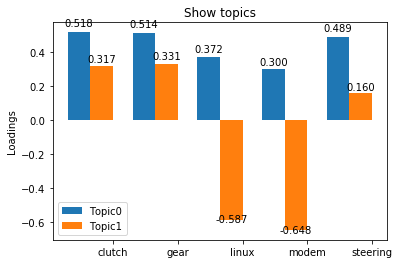

In [50]:
plot_topics(topics)

**Important Note:** Notice the effect of cleaning up _stop words_ when running LSA on the term frequency matrix. Results look more believable! Further, the separation between words _clutch_, _gear_, _steering_ ('cars') and _modem_, _linux_ ('IT') is more clear and the loading magnitudes seem to reflect topic relevance better.

In [51]:
lsi.projection.u # left singular vectors (U)

array([[ 0.30024393, -0.64782113],
       [ 0.48911522,  0.15959877],
       [ 0.37171036, -0.58689171],
       [ 0.5183769 ,  0.31707865],
       [ 0.513553  ,  0.33147438]])

In [52]:
lsi.projection.s # singular values (Ʃ)

array([ 8.83493413,  6.462851  ])

In [53]:
corpus_lsi = lsi[bow]

# https://github.com/RaRe-Technologies/gensim/wiki/Recipes-&-FAQ#q3-how-do-you-calculate-the-matrix-v-in-lsi-space
(corpus2dense(corpus_lsi, len(lsi.projection.s)).T / lsi.projection.s).T # right singular vectors (V^T)

array([[ 0.37287627,  0.38704343,  0.61723412,  0.5746153 ],
       [-0.62399118, -0.56360224,  0.33338883,  0.42642631]])

In [54]:
for doc in corpus_lsi:
     print(doc)

[(0, 3.2943372469083418), (1, -4.0327621295130189)]
[(0, 3.4195031421177706), (1, -3.6424772099715907)]
[(0, 5.4532226067907352), (1, 2.154642322857971)]
[(0, 5.0766883466956454), (1, 2.7559297667574407)]


## On bow matrix with removed stop words, with scikit-learn

In [55]:
from sklearn.utils.extmath import randomized_svd

bow_sparse = corpus2csc(bow)
U, Sigma, VT = randomized_svd(bow_sparse, n_components=2)

In [56]:
print(U)

[[ 0.30024393  0.64782113]
 [ 0.48911522 -0.15959877]
 [ 0.37171036  0.58689171]
 [ 0.5183769  -0.31707865]
 [ 0.513553   -0.33147438]]


In [57]:
print(Sigma)

[ 8.83493413  6.462851  ]


In [58]:
print(VT)

[[ 0.37287627  0.38704342  0.6172341   0.5746153 ]
 [ 0.6239912   0.56360223 -0.33338883 -0.42642632]]


Using [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) below to 1) perform dimensionality reduction on the doc-term matrix, 2) get extra characteristics like explained variance

In [59]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=1)
svd.fit(bow_sparse)
print(svd.transform(bow_sparse))

[[ 2.65263533  4.18677147]
 [ 4.32130074 -1.03146305]
 [ 3.28403659  3.79299367]
 [ 4.57982573 -2.04923205]
 [ 4.53720693 -2.14226954]]


In [60]:
'''SVD suffers from a problem called "sign indeterminancy", which means the
sign of the ``components_`` and the output from transform depend on the
algorithm and random state. To work around this, fit instances of this
class to data once, then keep the instance around to do transformations.'''
print(svd.components_) # V^T

[[ 0.37287627  0.38704342  0.6172341   0.5746153 ]
 [ 0.6239912   0.56360223 -0.33338883 -0.42642632]]


In [61]:
print(svd.singular_values_)

[ 8.83493413  6.462851  ]


In [62]:
print(svd.explained_variance_)

[ 0.59557896  8.04969065]


In [63]:
print(svd.explained_variance_ratio_)

[ 0.06152675  0.83157961]


## On tf-idf matrix with removed stop words, with gensim

In [64]:
model = models.TfidfModel(bow)
tfidf = [model[doc] for doc in bow]
tfidf

[[(0, 0.936603022962913), (1, 0.19436268823376643), (2, 0.29154403235064963)],
 [(0, 0.8624176140851579),
  (2, 0.47724753317857443),
  (3, 0.11931188329464361),
  (4, 0.11931188329464361)],
 [(1, 0.50709255283711),
  (2, 0.1690308509457033),
  (3, 0.6761234037828132),
  (4, 0.50709255283711)],
 [(1, 0.5144957554275266), (3, 0.5144957554275266), (4, 0.6859943405700354)]]

In [65]:
lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=2) # initialize an LSI transformation
topics = lsi.show_topics(-1, formatted=False)
topics

[(0,
  [('modem', 0.59280867897579448),
   ('clutch', 0.44086098310754573),
   ('gear', 0.43846231302340405),
   ('steering', 0.40457453895574552),
   ('linux', 0.31351189162667192)]),
 (1,
  [('modem', -0.70667985454335458),
   ('gear', 0.41846508669942178),
   ('clutch', 0.41229356914699117),
   ('steering', 0.31574804740101936),
   ('linux', -0.23623661400957205)])]

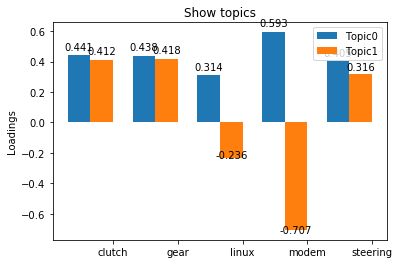

In [66]:
plot_topics(topics)

Same topics and loadings as before stop word removal - which makes sense since tf-idf was robust enough back then to zero-out the loading for 'the'.

In [67]:
print(lsi.projection.u) # left singular vectors (U)

[[ 0.59280868 -0.70667985]
 [ 0.40457454  0.31574805]
 [ 0.31351189 -0.23623661]
 [ 0.44086098  0.41229357]
 [ 0.43846231  0.41846509]]


In [68]:
print(lsi.projection.s) # singular values (Ʃ)

[ 1.50330866  1.28357349]


In [69]:
corpus_lsi = lsi[tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

# https://github.com/RaRe-Technologies/gensim/wiki/Recipes-&-FAQ#q3-how-do-you-calculate-the-matrix-v-in-lsi-space
print((corpus2dense(corpus_lsi, len(lsi.projection.s)).T / lsi.projection.s).T) # right singular vectors (V^T)

[[ 0.48244458  0.50939982  0.5179025   0.48942423]
 [-0.52149894 -0.48542378  0.47612706  0.51546638]]


In [70]:
for doc in corpus_lsi: # doc inference: both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
     print(doc)

[(0, 0.72526311682447542), (1, -0.66938222377208767)]
[(0, 0.76578514191849412), (1, -0.62307711556749179)]
[(0, 0.77856731972283255), (1, 0.61114406793638698)]
[(0, 0.735755652876521), (1, 0.66163900269049924)]


## On tf-idf matrix with removed stop words, with scikit-learn

In [71]:
from sklearn.utils.extmath import randomized_svd

# requires sparse matrix form of tfidf
tfidf_sparse = corpus2csc(tfidf)
U, Sigma, VT = randomized_svd(tfidf_sparse, n_components=2)

In [72]:
print(U)

[[ 0.59280868  0.70667985]
 [ 0.40457454 -0.31574805]
 [ 0.31351189  0.23623661]
 [ 0.44086098 -0.41229357]
 [ 0.43846231 -0.41846509]]


In [73]:
print(Sigma)

[ 1.50330866  1.28357349]


In [74]:
print(VT)

[[ 0.48244458  0.50939981  0.5179025   0.48942421]
 [ 0.52149895  0.4854238  -0.47612706 -0.5154664 ]]


Using [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) below to 1) perform dimensionality reduction on the doc-term matrix, 2) get extra characteristics like explained variance

http://scikit-learn.org/stable/modules/decomposition.html#lsa

In [75]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=1)
svd.fit(tfidf_sparse)
print(svd.transform(tfidf_sparse)) # dimensionality reduction on original bow matrix: word inference (? TODO)

[[ 0.89117442  0.90707552]
 [ 0.60820041 -0.40528582]
 [ 0.47130514  0.30322705]
 [ 0.66275013 -0.52920909]
 [ 0.65914419 -0.53713069]]


In [76]:
'''SVD suffers from a problem called "sign indeterminancy", which means the
sign of the ``components_`` and the output from transform depend on the
algorithm and random state. To work around this, fit instances of this
class to data once, then keep the instance around to do transformations.'''
print(svd.components_) # V^T

[[ 0.48244458  0.50939981  0.5179025   0.48942421]
 [ 0.52149895  0.4854238  -0.47612706 -0.5154664 ]]


**Small note:** Up to this point, these results have been exactly the same as _On tf-idf matrix, with scikit-learn_. Explained variance characteristics, however, have changed below.

In [77]:
print(svd.singular_values_)

[ 1.50330866  1.28357349]


In [78]:
print(svd.explained_variance_)

[ 0.01834557  0.32678059]


In [79]:
print(svd.explained_variance_ratio_)

[ 0.05047117  0.89901829]


I wonder if tf-idf struggles with such a small corpus... I prefer the results here from bow LSA, despite the suggestions from the experts. However, I should probably run a larger analyses before coming to a conclusion on which is better.

# NMF

Non-negative Matrix Factorization

"NMF is an alternative approach to decomposition that **assumes that the data and the components are non-negative**. NMF can be **plugged in instead of PCA or its variants**, in the cases where the data matrix does not contain negative values."

Base code: http://scikit-learn.org/0.18/auto_examples/applications/topics_extraction_with_nmf_lda.html

In [80]:
def show_topics(model, feature_names, n_top_words, formatted=True):
    if formatted:
        return [(topic_idx, " + ".join([f'{topic[i]:.3f}*"{tfidf_feature_names[i]}"' for i in topic.argsort()[:-n_top_words - 1:-1]])) for topic_idx, topic in enumerate(nmf.components_)]
    else:
        return [(topic_idx, [(feature_names[i], topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]) for topic_idx, topic in enumerate(model.components_)]

In [81]:
from sklearn.decomposition import NMF

n_topics = 2
n_top_words = 20

# Fit the NMF model
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_sparse.T) # Why transpose? Because NMF automatically clusters the columns of input data - so we transpose to put the words as columns

tfidf_feature_names = list(dictionary.token2id)
topics = show_topics(nmf, tfidf_feature_names, n_top_words, formatted=False)
topics

[(0,
  [('gear', 0.66317597152875785),
   ('clutch', 0.66135613666721849),
   ('steering', 0.55830475837561955),
   ('linux', 0.069870732649038522),
   ('modem', 0.0)]),
 (1,
  [('modem', 1.0572125809119941),
   ('linux', 0.42441743618047406),
   ('steering', 0.043558123419308349),
   ('gear', 0.0),
   ('clutch', 0.0)])]

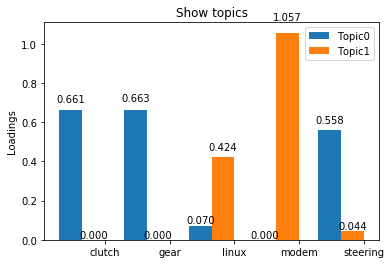

In [82]:
plot_topics(topics)

Topic separation (for this toy example at least) is much cleaner with NMF than LSA.

In [83]:
print(nmf.components_) # document scores per topic (H)

[[ 0.          0.55830476  0.06987073  0.66135614  0.66317597]
 [ 1.05721258  0.04355812  0.42441744  0.          0.        ]]


In [84]:
print(nmf.transform(tfidf_sparse.T)) # word scores per topic (W)

[[ 0.02899529  0.79336551]
 [ 0.07958809  0.78535598]
 [ 0.82681189  0.        ]
 [ 0.83008648  0.        ]]


# pLSA

Probabilistic Latent Semantic Analysis

"Previous studies (Ding, Li, and Peng 2006; Gaussier and Goutte 2005) have suggested that **PLSA and Kullback-Leibler (KL) divergence based Non-negative Matrix Factorization (NMF) indeed optimize the same objective function** although they converge to different local minima. It is noteworthy that, as a widely used dimension reduction technique, traditional NMF with Frobenius norm performs well for document clustering and topic modeling (Arora et al. 2012; 2013; Kuang, Choo, and Park 2015), although it
lacks explicit probabilistic meaning of factors." - https://aaai.org/ocs/index.php/AAAI/AAAI17/paper/view/14469/14409

Going to use NMF with Kullback-Leibler divergence as the _distance function_ to approximate pLSA

In [85]:
# Fit the NMF model
plsa = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5, beta_loss='kullback-leibler', solver='mu').fit(tfidf_sparse.T)

tfidf_feature_names = list(dictionary.token2id)
topics = show_topics(plsa, tfidf_feature_names, n_top_words, formatted=False)
topics

[(0,
  [('gear', 0.66747703525252677),
   ('clutch', 0.66624288185263969),
   ('steering', 0.61918510352655765),
   ('linux', 0.098940858079460015),
   ('modem', 0.0)]),
 (1,
  [('modem', 1.0643330351655236),
   ('linux', 0.44958075309310869),
   ('gear', 0.0),
   ('clutch', 0.0),
   ('steering', 0.0)])]

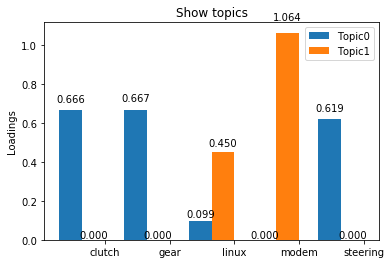

In [86]:
plot_topics(topics)

**TODO**: Can this be run on BOW?

# LDA

"LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics **can be interpreted as probability distributions over words**... Documents are in turn interpreted as a (soft) mixture of these topics (again, just like with LSA)." - https://radimrehurek.com/gensim/tut2.html

"Latent Dirichlet Allocation is a generative probabilistic model for collections of discrete dataset such as text corpora. It is also a topic model that is used for discovering abstract topics from a collection of documents.
The graphical model of LDA is a three-level Bayesian model" - http://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation

In [87]:
#lda = models.LdaModel(tfidf, id2word=dictionary, num_topics=2)
lda = models.LdaModel(tfidf,
                        id2word=dictionary,
                        num_topics=n_topics,
                        alpha='symmetric',
                        eta=None,
                        decay=0,
                        offset=1,
                        eval_every=1,
                        iterations=10,
                        random_state=1,
                        update_every=0,
                        passes=3)
topics = lda.show_topics(-1, formatted=False)
topics

[(0,
  [('modem', 0.41602116481611484),
   ('linux', 0.23395559106886746),
   ('steering', 0.12317508020849258),
   ('gear', 0.11529712025708076),
   ('clutch', 0.11155104364944435)]),
 (1,
  [('clutch', 0.27786884894274089),
   ('gear', 0.27493853851228101),
   ('steering', 0.25218254757870806),
   ('linux', 0.10820384876933335),
   ('modem', 0.086806216196936695)])]

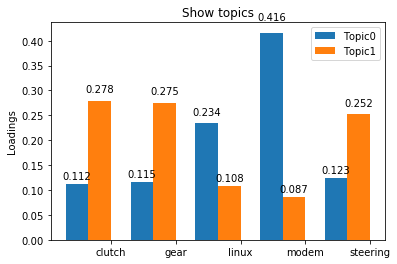

In [88]:
plot_topics(topics)

In [89]:
[topic[1] for topic in lda.top_topics(tfidf)] # coherence for each topic

[-0.4106767082195325, -0.57286275146279819]

In [90]:
lda.log_perplexity(tfidf)

-2.3812367532776038